In [1]:
%pip install yfinance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [58]:
np.random.seed(42)

In [30]:
sk_hynix = yf.download("000660.KS", start="2015-01-01", end="2025-11-13")

/tmp/ipython-input-2754962096.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sk_hynix = yf.download("000660.KS", start="2015-01-01", end="2025-11-13")
[*********************100%***********************]  1 of 1 completed


In [59]:
sk_hynix.head()

Price,Close,High,Low,Open,Volume,Returns,LogReturns,MA20,MA60,Volatility20,Volatility
Ticker,000660.KS,000660.KS,000660.KS,000660.KS,000660.KS,,,,,,
Date,,,,,,,,,,,
2015-01-02,41524.937500,42090.198429,41437.974280,41698.863940,1155944,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,41437.972656,42090.196780,41307.527832,41785.825522,1409146,-0.002094,-0.002096,NaN,NaN,NaN,NaN
2015-01-06,41307.527344,41394.490559,40785.748051,40872.711266,1661196,-0.003148,-0.003153,NaN,NaN,NaN,NaN
2015-01-07,41220.558594,41394.485001,40611.816167,40611.816167,1821266,-0.002105,-0.002108,NaN,NaN,NaN,NaN
2015-01-08,43438.125000,43481.606607,41655.379129,41959.750375,5006675,0.053798,0.052400,NaN,NaN,NaN,NaN


In [60]:
#결측치 체크
sk_hynix.isnull().sum()

,,0
Price,Ticker,
Close,000660.KS,0
High,000660.KS,0
Low,000660.KS,0
Open,000660.KS,0
Volume,000660.KS,0
Returns,,1
LogReturns,,1
MA20,,19
MA60,,59


In [61]:
sk_hynix['Returns'] = sk_hynix['Close'].pct_change()
sk_hynix['LogReturns'] = np.log(sk_hynix['Close'] / sk_hynix['Close'].shift(1))
sk_hynix['MA20'] = sk_hynix['Close'].rolling(window=20).mean()
sk_hynix['MA60'] = sk_hynix['Close'].rolling(window=60).mean()
sk_hynix['Volatility20'] = sk_hynix['Returns'].rolling(window=20).std()
sk_hynix['Volatility'] = sk_hynix['Volatility20']* np.sqrt(252)  #Annualized Volatility

In [62]:
#분석에 쓰일 종가 데이터: 영업일 기준 resample (주 5회)
sk_daily = sk_hynix['Close'].dropna().asfreq('B')
sk_daily = sk_daily.fillna(method='ffill')

print(sk_daily.tail(3))

Ticker      000660.KS
Date                 
2025-11-10   606000.0
2025-11-11   619000.0
2025-11-12   617000.0


/tmp/ipython-input-3884972910.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sk_daily = sk_daily.fillna(method='ffill')


In [63]:
print(sk_daily.head())

Ticker         000660.KS
Date                    
2015-01-02  41524.937500
2015-01-05  41437.972656
2015-01-06  41307.527344
2015-01-07  41220.558594
2015-01-08  43438.125000


In [64]:
sk_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2834 entries, 2015-01-02 to 2025-11-12
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   000660.KS  2834 non-null   float64
dtypes: float64(1)
memory usage: 44.3 KB


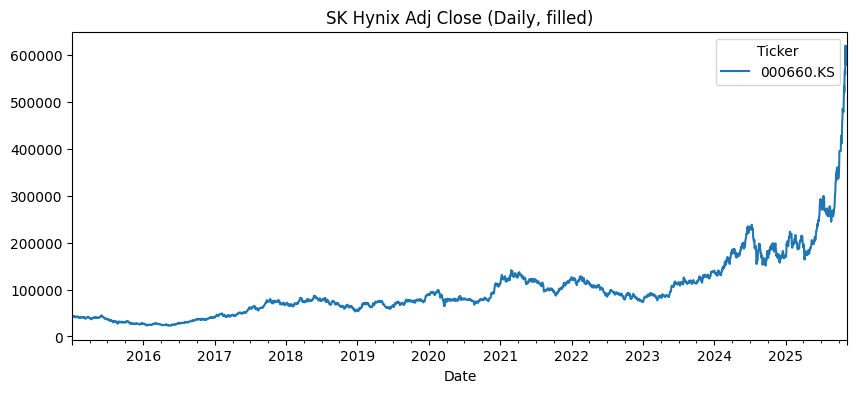

In [65]:
sk_daily.plot(title="SK Hynix Adj Close (Daily, filled)", figsize=(10,4))
plt.show()

In [66]:
def train_test_split_series(series: pd.Series, test_size: int = 60):
    train = series.iloc[:-test_size]
    test  = series.iloc[-test_size:]
    return train, test

def metrics(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

In [70]:
test_size = int(0.2*len(sk_daily))
train_d, test_d = train_test_split_series(sk_daily, test_size=test_size)
train_log,test_log = np.log(train_d),np.log(test_d)

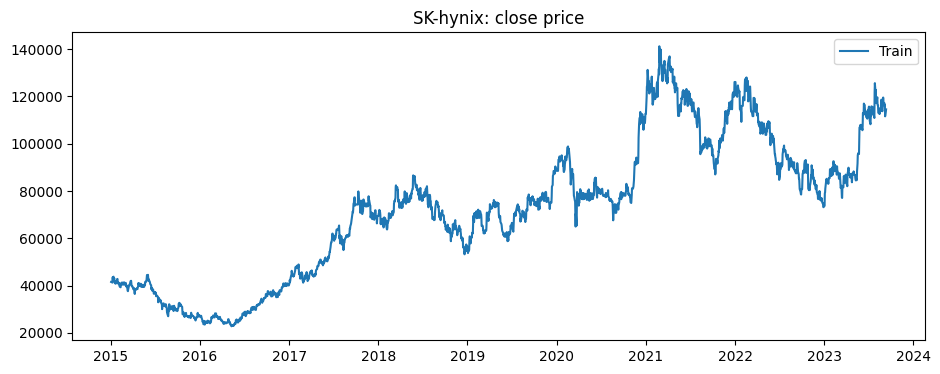

In [71]:
plt.figure(figsize=(11,4))
plt.plot(train_d, label="Train")
plt.title("SK-hynix: close price")
plt.legend()
plt.show()

### 1. SES(Simple Exponential Smoothing)

Test Set Metrics:
MAE: 91316.3209
RMSE: 125987.3526
MAPE(%): 37.7058

Train Set Metrics:
MAE: 72522.1823
RMSE: 78195.2913
MAPE(%): 99.9810


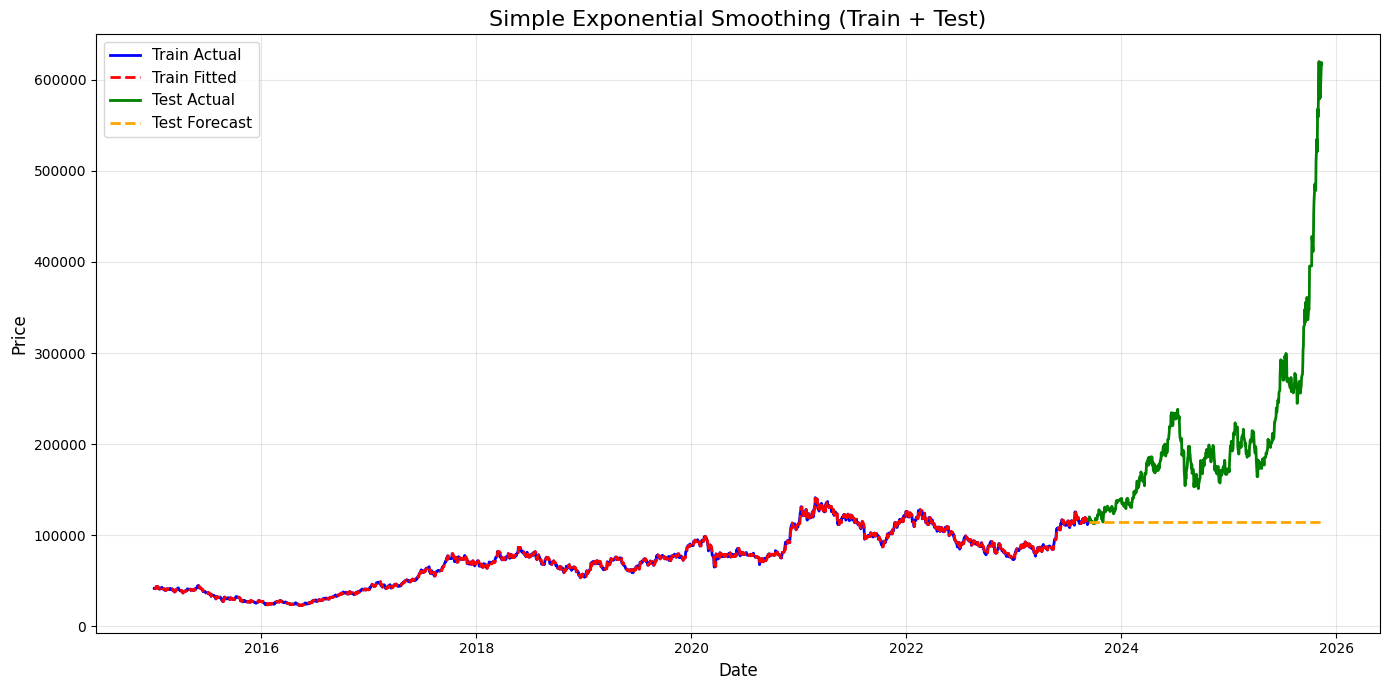

In [72]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_auto = SimpleExpSmoothing(train_log, initialization_method="estimated").fit(optimized=True)

ses_auto_fore = ses_auto.forecast(len(test_log))
ses_auto_fore = np.exp(ses_auto_fore)
ses_auto_fore.index = test_log.index

# Eval of Test
res_ses_auto = metrics(test_d, ses_auto_fore)
print("Test Set Metrics:")
for key, value in res_ses_auto.items():
    print(f"{key}: {value:.4f}")

# Eval of Train
train_metrics = metrics(train_d, ses_auto.fittedvalues)
print("\nTrain Set Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Plot: Train + Test Together

plt.figure(figsize=(14, 7))
plt.title("Simple Exponential Smoothing (Train + Test)", fontsize=16)

# Train Plot
plt.plot(train_d.index,
         train_d.values,
         label="Train Actual",
         color="blue",
         linewidth=2)

plt.plot(train_d.index,
         np.exp(ses_auto.fittedvalues),  # inverse-transform for plot
         label="Train Fitted",
         color="red",
         linestyle="--",
         linewidth=2)

# Test Plot
plt.plot(test_d.index,
         test_d.values,
         label="Test Actual",
         color="green",
         linewidth=2)

plt.plot(test_d.index,
         ses_auto_fore.values,
         label="Test Forecast",
         color="orange",
         linestyle="--",
         linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2. Holt-Winter's
trend와 seasonality를 둘다 모델링하도록 Holt Winter 써봄. 이때, monthly seasonality로 만들려면 월별 데이터로 resample해야하므로 그냥 weekly seasonality로 모델링

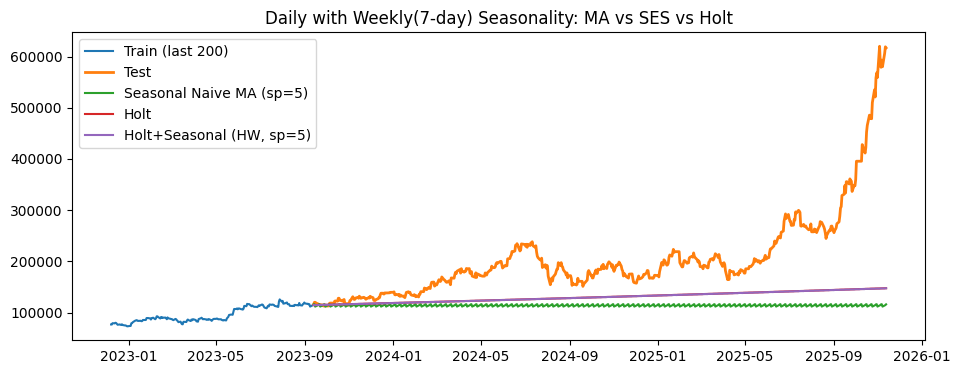

,MAE,RMSE,MAPE(%)
Holt(linear),77928.134350,115428.501213,31.101744
Holt(seasonal),77993.849254,115483.778700,31.132153
MA(seasonal),91389.956948,126042.279092,37.750467


In [73]:
### Holt-Winter's(Trend+Seasonality)
# seasonal naive MA (preiod=5days)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def seasonal_naive_forecast(series, season_len, steps):
    pred = []
    hist = series.values
    for i in range(steps):
        pred.append(hist[-season_len + (i % season_len)])
    return pd.Series(pred, index=pd.date_range(series.index[-1] + pd.tseries.offsets.BDay(),
                                               periods=steps, freq="B"))

ma_seasonal = seasonal_naive_forecast(train_log.astype(float), season_len=5, steps=len(test_log))
ma_seasonal = ma_seasonal.astype(float)
ma_seasonal = np.exp(ma_seasonal)

holt = ExponentialSmoothing(train_log, trend="add", seasonal=None, initialization_method="estimated").fit(optimized=True)
holt_fore = holt.forecast(len(test_log))

#log-inverse transformation
holt_fore = np.exp(holt_fore)
holt_fore.index = test_log.index

holt_seasonal = ExponentialSmoothing(train_log,
                                     trend="add",
                                     seasonal="add",
                                     seasonal_periods=5,
                                     initialization_method="estimated").fit(optimized=True)
holt_seasonal_fore = holt_seasonal.forecast(len(test_log))
holt_seasonal_fore = np.exp(holt_seasonal_fore)
holt_seasonal_fore.index = test_log.index

plt.figure(figsize=(11,4))
plt.plot(train_d[-200:], label="Train (last 200)")
plt.plot(test_d, label="Test", linewidth=2)

plt.plot(ma_seasonal, label="Seasonal Naive MA (sp=5)")
plt.plot(holt_fore, label="Holt")
plt.plot(holt_seasonal_fore, label="Holt+Seasonal (HW, sp=5)")

plt.title("Daily with Weekly(7-day) Seasonality: MA vs SES vs Holt")
plt.legend()
plt.show()


perf = {
    "MA(seasonal)": metrics(test_d, ma_seasonal),
    "Holt(linear)": metrics(test_d, holt_fore),
    "Holt(seasonal)": metrics(test_d, holt_seasonal_fore)
}
pd.DataFrame(perf).T.sort_values("RMSE")

### 3. ARIMA


In [74]:
### 7. Stationary Check(ADF Test, ACF/PACF Plots)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

adf_result = adfuller(train_log.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -0.9728642169893892
p-value: 0.7630323642700526


the series is non-stationary

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_log.dropna(), lags=50)
plot_pacf(train_log.dropna(), lags=50)
plt.show()

그리고 ACF plot결과 seasonality도 없는 것으로 보임->만약 seasonality있다면 ACF plot에서 특정 lag 간격마다 peak가 반복되어야하고, 이때 해당 lag가 sarima 모델의 m(계절주기)에 해당하게 됨.->SARIMA대신 ARIMA 적용

In [44]:
%pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 31.4 MB/s eta 0:00:00


In [76]:
from pmdarima.arima import ndiffs
import pmdarima as pm

kpss_diffs = ndiffs(train_log, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_log, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


{'ADF': np.float64(0.7630323642700526), 'ADF diff': 0.0}


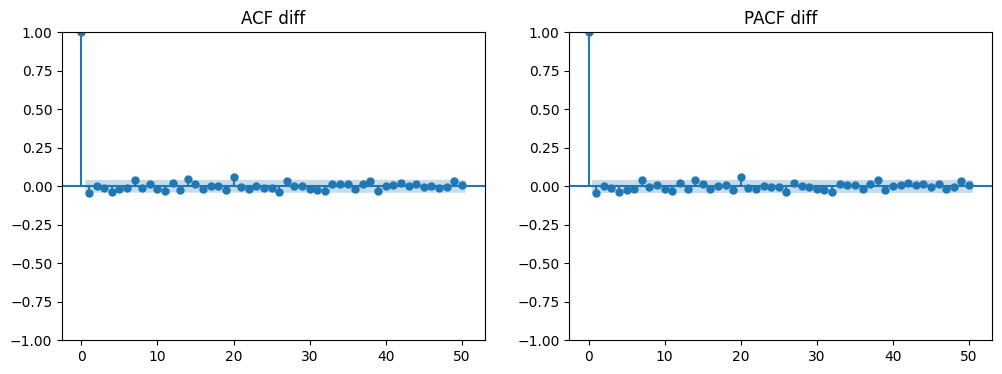

In [77]:
##그럼 first differencing 후에 stationary 인지 check->ADF test
from statsmodels.tsa.stattools import adfuller
train_diff = train_log.diff().dropna()
print({"ADF": adfuller(train_log)[1], "ADF diff": adfuller(train_diff)[1]})

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(train_diff, ax=axes[0], lags=50)
plot_pacf(train_diff, ax=axes[1], lags=50)
axes[0].set_title("ACF diff")
axes[1].set_title("PACF diff")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10882.894, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10884.779, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10884.763, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10883.949, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10882.787, Time=2.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10882.791, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10880.784, Time=1.94 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10885.755, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10883.766, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10883.772, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10885.735, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10881.763, Time=0.68 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 12.343 seconds
                               SARIMAX Results                 

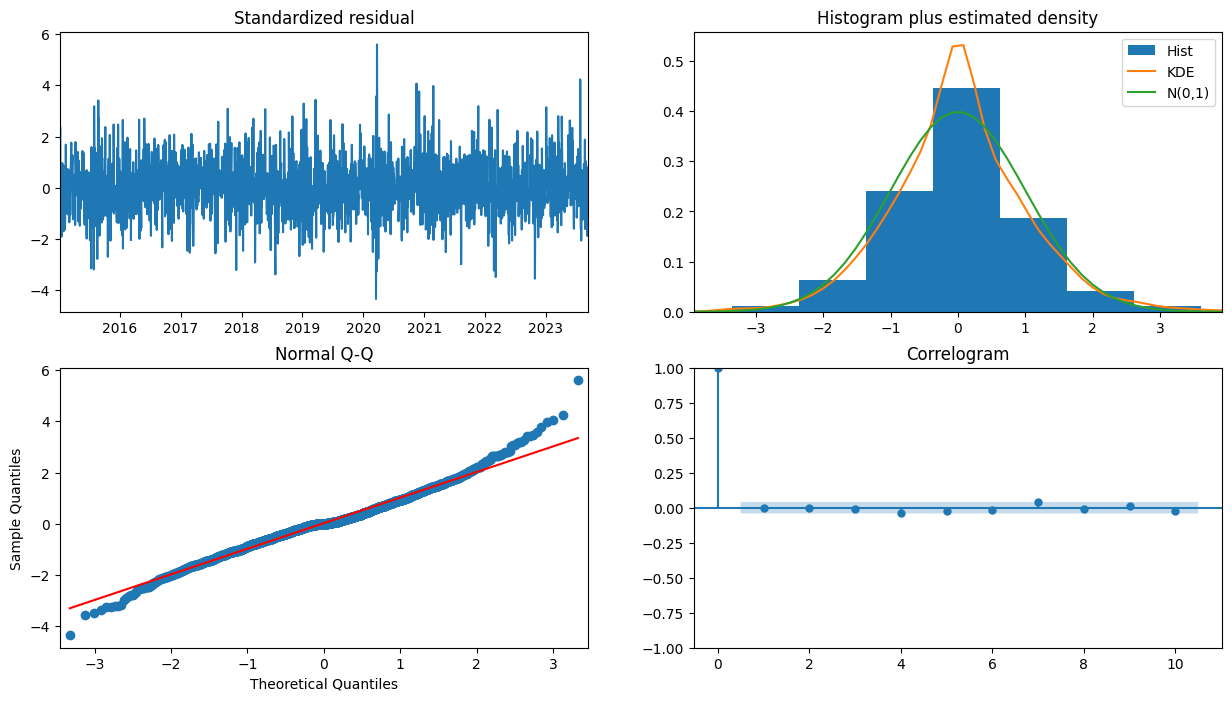

In [78]:
model_autoARIMA = pm.auto_arima(train_log, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

- **Ljung-Box(Q)**
:잔차가 백색잡음인지
검정한 통계량

- Probability = 0.99>.05 이므로 x reject null hypothesis: 잔차가 백색잡음 시계열을 따른다.
->시계열 모형이 잘 적합되었고, 남은 잔차는 더 이상 자기상관을 가지지 않는 백색 잡음이라고 해석할 수 있음.

- **Jarque-Bera(JB)**
는 잔차가 정규분포를 따르는지 검정한 통계량

- JB값을 보면 0.00로 유의수준 0,05에서 reject null hypothesis->잔차는 정규성을 따르지 않음.

->해당 arima 모델에 잔차는 정규성을 띄지 않는 백색잡음.

+ 잔차가 정규분포 따른다면, skew는 0에 가까워야하고, kurtosis는 3에 가까워야함.
위의 결과에서 skew는 0.21로 0에 가깝지만 kurtosis는 4.54로 3보다 더 높은 값이므로 정규분포를 따르지 않음을 알 수 있음.


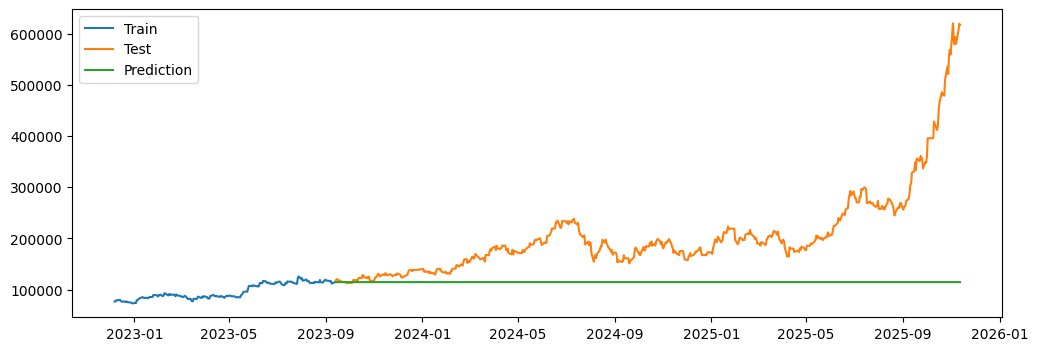

In [79]:
# 테스트 데이터 개수만큼 예측
predict_log = model_autoARIMA.predict(n_periods=len(test_log))
predict_log = pd.DataFrame(predict_log,index = test_log.index,columns=['Prediction'])
predicted_y = np.exp(predict_log)
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_d[-200:], label='Train')
plt.plot(test_d, label='Test')
plt.plot(predicted_y, label='Prediction')
plt.legend()
plt.show()

In [80]:
metrics(test_d, predicted_y)

{'MAE': np.float64(91312.01706930295),
 'RMSE': np.float64(125984.13050019219),
 'MAPE(%)': np.float64(37.703512558559105)}

### 4.LSTM

In [82]:
sk_data = sk_hynix[['Close','High','Low','Open','Volume']].dropna(how='all').asfreq('B')
sk_data = sk_data.fillna(method='ffill')
sk_data.head()

/tmp/ipython-input-669159214.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sk_data = sk_data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,000660.KS,000660.KS,000660.KS,000660.KS,000660.KS
Date,,,,,
2015-01-02,41524.937500,42090.198429,41437.974280,41698.863940,1155944.0
2015-01-05,41437.972656,42090.196780,41307.527832,41785.825522,1409146.0
2015-01-06,41307.527344,41394.490559,40785.748051,40872.711266,1661196.0
2015-01-07,41220.558594,41394.485001,40611.816167,40611.816167,1821266.0
2015-01-08,43438.125000,43481.606607,41655.379129,41959.750375,5006675.0


In [84]:
len(sk_data)

2834

In [85]:
sk_log = np.log(sk_data)
sk_log.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Price,Close,High,Low,Open,Volume
Ticker,000660.KS,000660.KS,000660.KS,000660.KS,000660.KS
Date,,,,,
2015-01-02,10.634049,10.647570,10.631953,10.638229,13.960428
2015-01-05,10.631953,10.647570,10.628800,10.640312,14.158494
2015-01-06,10.628800,10.630903,10.616088,10.618218,14.323048
2015-01-07,10.626692,10.630903,10.611814,10.611814,14.415042
2015-01-08,10.679093,10.680093,10.637186,10.644466,15.426283


In [87]:
sk_log.columns = ['log_close','log_high','log_low','log_open','log_volume']

In [88]:
sk_log_corr_df = sk_log.corr()

In [89]:
import seaborn as sns

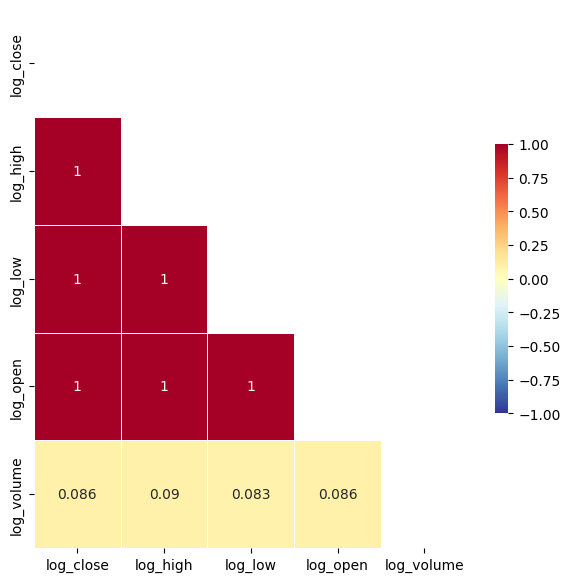

In [90]:
fig, ax = plt.subplots(figsize=(7,7))

mask = np.zeros_like(sk_log_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(sk_log_corr_df,
            cmap = 'RdYlBu_r',
            annot = True,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.show()

In [91]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sk_log = sk_log.drop(['log_volume'], axis=1)
sk_log['log_close2'] = sk_log['log_close']
sk_log_scaled = sk_log.copy()
sk_log_scaled.iloc[:,:4] = scaler.fit_transform(sk_log_scaled.iloc[:,:4])
sk_log_scaled.head()

,log_close,log_high,log_low,log_open,log_close2
Date,,,,,
2015-01-02,-1.092217,-1.092858,-1.076129,-1.088113,10.634049
2015-01-05,-1.095608,-1.092858,-1.081244,-1.084737,10.631953
2015-01-06,-1.100709,-1.119798,-1.101864,-1.120540,10.628800
2015-01-07,-1.104118,-1.119798,-1.108796,-1.130917,10.626692
2015-01-08,-1.019355,-1.040288,-1.067641,-1.078006,10.679093


In [107]:
from sklearn.model_selection import train_test_split
import numpy as np

def generate_dataset(df,input_idx,target_idx, window_size, test_n=90):
    x = []
    y = []

    for i in range(len(df) - window_size):
        # feature = df.iloc[rows, columns 0~3]
        input_data = df.iloc[i:i + window_size, 0:input_idx].values
        x.append(input_data)
        output_data = df.iloc[i + window_size, target_idx]
        y.append(output_data)

    x = np.array(x)
    y = np.array(y)


    # 2. Train/Test split
    test_idx = len(df) - test_n
    split_point = test_idx - window_size

    x_train = x[:split_point]
    y_train = y[:split_point]

    x_test = x[split_point:]
    y_test = y[split_point:]

    # 3. Train/Val split
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train,
        test_size=0.1,
        shuffle=True
    )
    print(f"# Train data: {y_train.shape[0]}")
    print(f"# Val data:   {y_val.shape[0]}")
    print(f"# Test data:  {y_test.shape[0]}")

    return x_train, y_train, x_val, y_val, x_test, y_test




     Running Window Size = 25

# Train data: 2018
# Val data:   225
# Test data:  566
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 8.9096 - mae: 8.9096 - val_loss: 1.1316 - val_mae: 1.1316
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1332 - mae: 2.1332 - val_loss: 0.7694 - val_mae: 0.7694
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9756 - mae: 1.9756 - val_loss: 0.3452 - val_mae: 0.3452
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8204 - mae: 1.8204 - val_loss: 0.4901 - val_mae: 0.4901
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7852 - mae: 1.7852 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7524 - mae: 1.7524 - val_loss: 0.2895 - val_mae: 0.2895
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.8077 - mae: 1.8077 - val_loss: 0.4149 - val_mae: 0.4149
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6810 - mae: 1.6810 - val

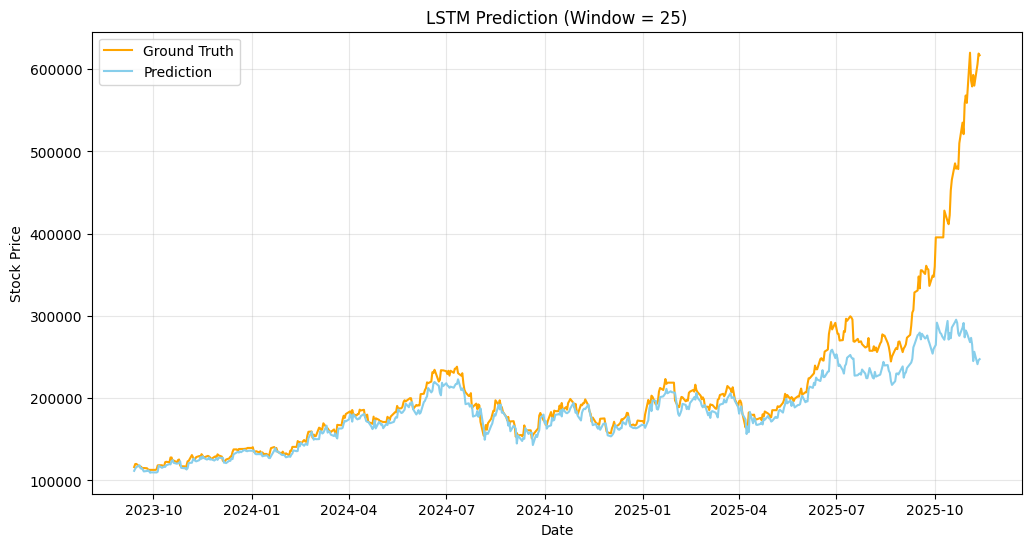


Metrics:
{'MAE': np.float64(23458.767115724375), 'RMSE': np.float64(58640.08150003129), 'MAPE(%)': np.float64(7.427295341675285)}


     Running Window Size = 50

# Train data: 1996
# Val data:   222
# Test data:  566
Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.7050 - mae: 8.7050 - val_loss: 2.7940 - val_mae: 2.7940
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8206 - mae: 2.8206 - val_loss: 0.2666 - val_mae: 0.2666
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6775 - mae: 1.6775 - val_loss: 0.0954 - val_mae: 0.0954
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.5655 - mae: 1.5655 - val_loss: 0.4194 - val_mae: 0.4194
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.5912 - mae: 1.5912 - val_loss: 0.1866 - val_mae: 0.1866
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.4956 - mae: 1.4956 - val_loss: 0.6353 - val_mae: 0.6353
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.5561 - mae:

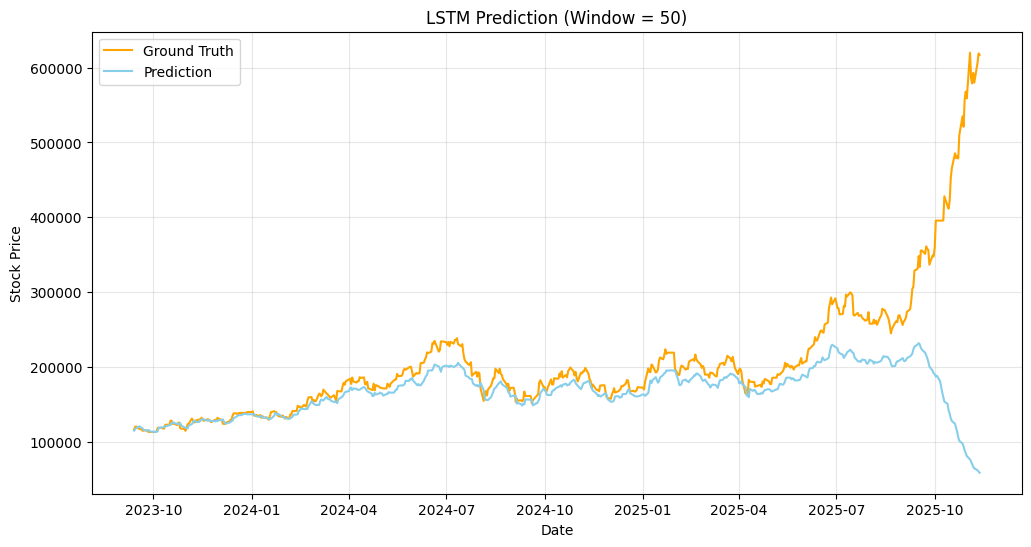


Metrics:
{'MAE': np.float64(39701.14963145981), 'RMSE': np.float64(97981.2125769583), 'MAPE(%)': np.float64(12.303895383353817)}


     Running Window Size = 100

# Train data: 1951
# Val data:   217
# Test data:  566
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 8.9003 - mae: 8.9003 - val_loss: 2.5063 - val_mae: 2.5063
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.1391 - mae: 3.1391 - val_loss: 0.5669 - val_mae: 0.5669
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.7422 - mae: 1.7422 - val_loss: 0.3361 - val_mae: 0.3361
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 1.6735 - mae: 1.6735 - val_loss: 0.2098 - val_mae: 0.2098
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.5396 - mae: 1.5396 - val_loss: 0.2303 - val_mae: 0.2303
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.5859 - mae: 1.5859 - val_loss: 0.7079 - val_mae: 0.7079
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.5233 - mae:

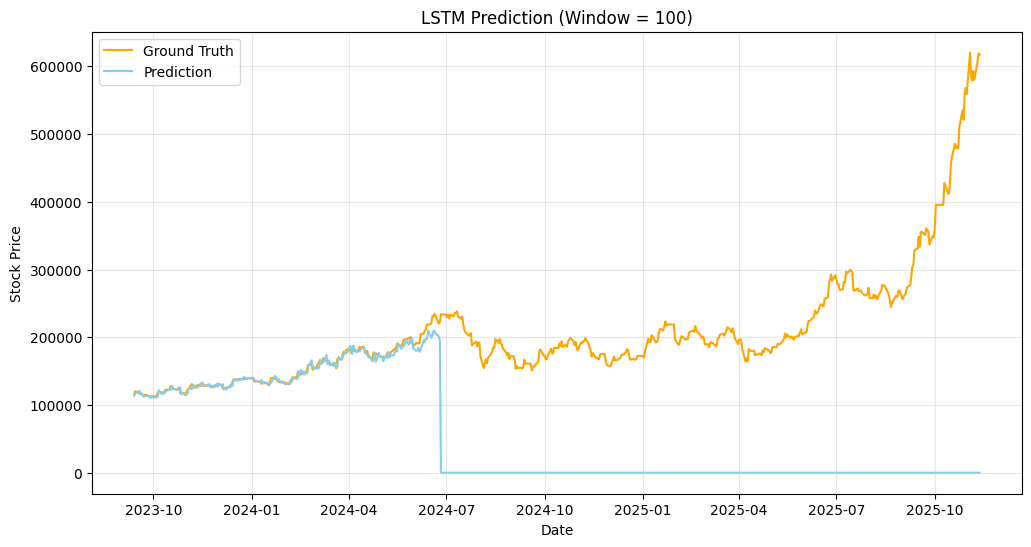


Metrics:
{'MAE': np.float64(152234.11421381205), 'RMSE': np.float64(202923.82677643007), 'MAPE(%)': np.float64(64.71348019315117)}

============== Summary ==============
Window Size 25 → Test MAE = {'MAE': np.float64(23458.767115724375), 'RMSE': np.float64(58640.08150003129), 'MAPE(%)': np.float64(7.427295341675285)}
Window Size 50 → Test MAE = {'MAE': np.float64(39701.14963145981), 'RMSE': np.float64(97981.2125769583), 'MAPE(%)': np.float64(12.303895383353817)}
Window Size 100 → Test MAE = {'MAE': np.float64(152234.11421381205), 'RMSE': np.float64(202923.82677643007), 'MAPE(%)': np.float64(64.71348019315117)}



In [111]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os


# 1. LSTM 모델

def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=False
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=Adam(0.001),
        metrics=['mae']
    )
    return model


def run_experiment(df,input_idx,target_idx,window_size):

    print(f"\n\n====================================")
    print(f"     Running Window Size = {window_size}")
    print(f"====================================\n")

    # 데이터 생성
    test_n = int(0.2*len(df))
    x_train, y_train, x_val, y_val, x_test, y_test = generate_dataset(df,input_idx,target_idx, window_size,test_n)


    model = build_lstm((x_train.shape[1], x_train.shape[2]))


    checkpoint_path = f"/content/best_lstm_ws_datacol{input_idx}_window{window_size}.weights.h5"

    cbk = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_mae',
        mode='min',
        save_best_only=True
    )
    es = keras.callbacks.EarlyStopping(
        patience=50,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        x_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[cbk, es],
        verbose=1
    )


    model.load_weights(checkpoint_path)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest MAE:", score[1])
    y_pred = model.predict(x_test)


    #Date index 추출
    test_idx = len(df) - test_n
    split_point = test_idx - window_size
    test_start_index = split_point + window_size
    date_index_for_test = df.index[test_start_index : test_start_index + len(y_test)]

     #inverse transform
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(date_index_for_test, y_test, label='Ground Truth', color='orange')
    plt.plot(date_index_for_test, y_pred, label='Prediction', color='skyblue')
    plt.title(f'LSTM Prediction (Window = {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    result = metrics(y_test, y_pred.flatten())

    print("\nMetrics:")
    print(result)

    return result


results = {}
for ws in [25, 50, 100]:
    results[ws] = run_experiment(sk_log_scaled,4,4,ws)

print("\n============== Summary ==============")
for ws, mae in results.items():
    print(f"Window Size {ws} → Test MAE = {mae}")
print("=====================================\n")




     Running Window Size = 25

# Train data: 2018
# Val data:   225
# Test data:  566
Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.5490 - mae: 9.5490 - val_loss: 0.3883 - val_mae: 0.3883
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2143 - mae: 2.2143 - val_loss: 0.7445 - val_mae: 0.7445
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.0820 - mae: 2.0820 - val_loss: 0.7196 - val_mae: 0.7196
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.0037 - mae: 2.0037 - val_loss: 0.6520 - val_mae: 0.6520
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8817 - mae: 1.8817 - val_loss: 0.4496 - val_mae: 0.4496
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8182 - mae: 1.8182 - val_loss: 0.8209 - val_mae: 0.8209
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8173 - mae: 1.8173 - val_loss: 0.3971 - val_mae: 0.3971
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7455 - mae: 1.7455 - val_loss: 0.6680 - val_mae: 0.6680
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7125 -

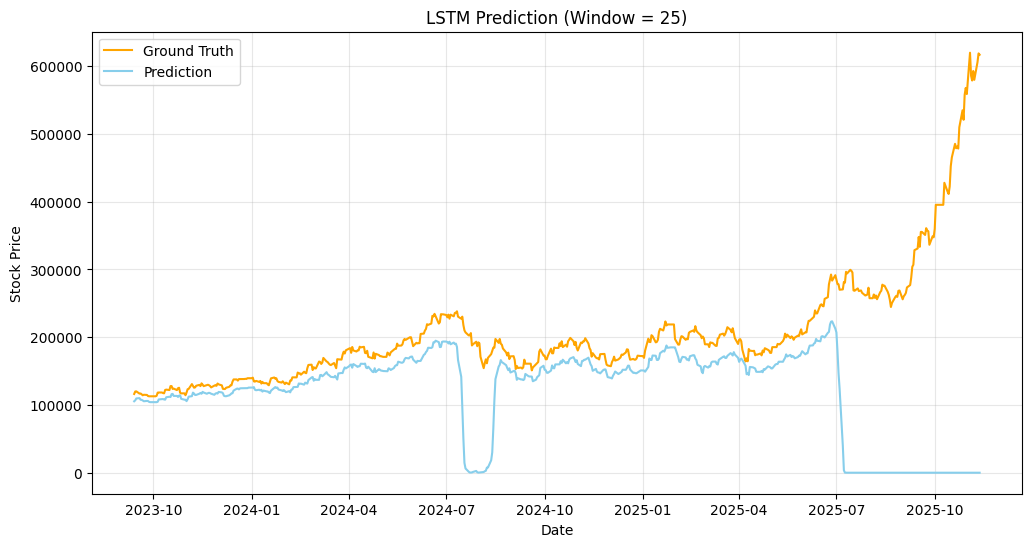


Metrics:
{'MAE': np.float64(85152.46186432484), 'RMSE': np.float64(157153.17325009708), 'MAPE(%)': np.float64(30.769943437548868)}


     Running Window Size = 50

# Train data: 1996
# Val data:   222
# Test data:  566
Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 9.7844 - mae: 9.7844 - val_loss: 0.7210 - val_mae: 0.7210
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.2623 - mae: 2.2623 - val_loss: 0.4853 - val_mae: 0.4853
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.9837 - mae: 1.9837 - val_loss: 1.0131 - val_mae: 1.0131
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7999 - mae: 1.7999 - val_loss: 0.4467 - val_mae: 0.4467
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.7358 - mae: 1.7358 - val_loss: 0.2480 - val_mae: 0.2480
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.5873 - mae: 1.5873 - val_loss: 0.8446 - val_mae: 0.8446
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.7063 - mae

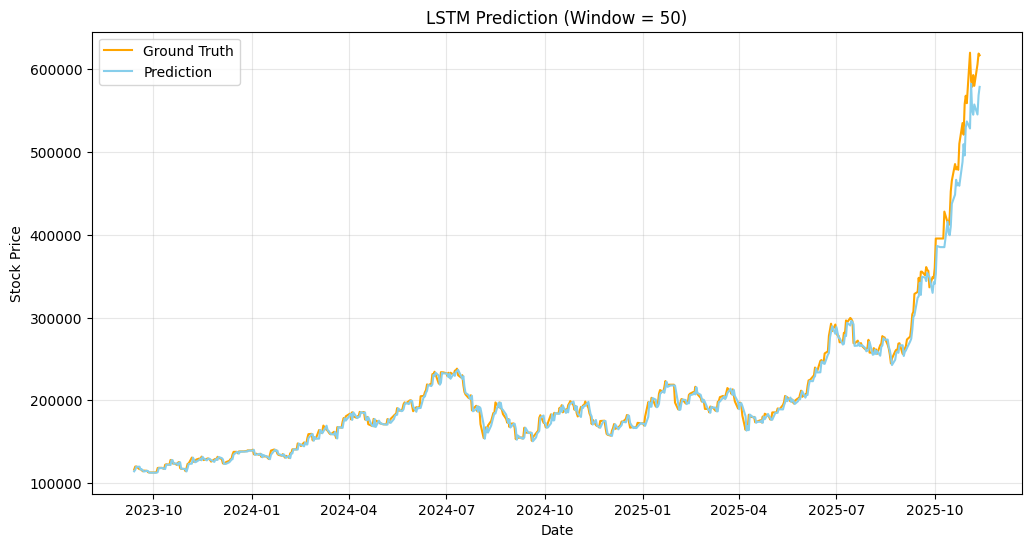


Metrics:
{'MAE': np.float64(5696.463270207595), 'RMSE': np.float64(10330.938120197612), 'MAPE(%)': np.float64(2.3909086328732685)}


     Running Window Size = 100

# Train data: 1951
# Val data:   217
# Test data:  566
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 8.6247 - mae: 8.6247 - val_loss: 2.2995 - val_mae: 2.2995
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.2698 - mae: 3.2698 - val_loss: 1.2579 - val_mae: 1.2579
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 2.1537 - mae: 2.1537 - val_loss: 0.4130 - val_mae: 0.4130
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.7783 - mae: 1.7783 - val_loss: 0.2522 - val_mae: 0.2522
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.6714 - mae: 1.6714 - val_loss: 0.4385 - val_mae: 0.4385
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 1.6846 - mae: 1.6846 - val_loss: 0.4493 - val_mae: 0.4493
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 1.6588 - ma

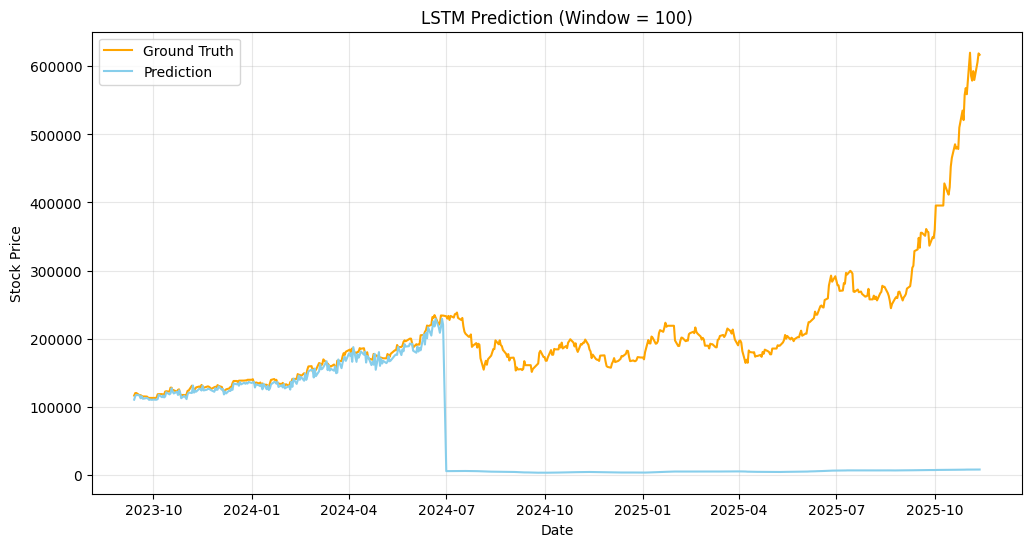


Metrics:
{'MAE': np.float64(148439.39028812046), 'RMSE': np.float64(198274.17863699154), 'MAPE(%)': np.float64(63.22003394138223)}

============== Summary ==============
Window Size 25 → Test MAE = {'MAE': np.float64(85152.46186432484), 'RMSE': np.float64(157153.17325009708), 'MAPE(%)': np.float64(30.769943437548868)}
Window Size 50 → Test MAE = {'MAE': np.float64(5696.463270207595), 'RMSE': np.float64(10330.938120197612), 'MAPE(%)': np.float64(2.3909086328732685)}
Window Size 100 → Test MAE = {'MAE': np.float64(148439.39028812046), 'RMSE': np.float64(198274.17863699154), 'MAPE(%)': np.float64(63.22003394138223)}



In [110]:
#종가 단일 데이터로 LSTM prediction
results2 = {}
for ws in [25, 50, 100]:
    results2[ws] = run_experiment(sk_log_scaled,1,4,ws)

print("\n============== Summary ==============")
for ws, mae in results2.items():
    print(f"Window Size {ws} → Test MAE = {mae}")
print("=====================================\n")

** LSTM result**
time dependency 기준을 영업일(5)에 대해 각각 5주(=25),10주(=50),20주(=100)으로 나눠서 돌려봄
- 1)open,close,high,low 데이터->close예측:window_size=25이 best
- 2)close단일->close예측:window size=50이 best(window_size 너무 크면 주가 예측 특성에도 안맞고 vanishing gradient때문에 학습이 어려울 수도 있을 듯)
->단일 데이터 예측 성능이 더 좋게 나옴.